Dataset: Daily Minimum Temperatures in Melbourne

Time series data is a combination of Trend, Cycles, Seasonality and Residuals.

This notebook is composed of the below steps:

    1) Check for Stationarity (Both Deterministic and Stochastic)
    
    2) If data is not Stationary, transform the data to Stationary to fit for the Statistical models like ARIMA
    
    3) Fit an ARIMA model and predict future temperatures using the Stationary data, we add the trend component (if any) in the end to the forecast of the ARIMA model.
    
    4) Fit an LSTM using the Original Data and predict future temperatures
    
    5) Cross Validate the LSTM predictions for k=5 and k=10
    
    6) Compare the results of ARIMA with LSTM

In [1]:
#Import Libraries

from datetime import datetime
import warnings
import itertools
import pandas as pd 
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [12.0,8.0]
pd.options.mode.use_inf_as_na = True

In [2]:
#Loading the Dataset

missing_values = ["na", "--"] #other possible values not specified in default "na_values"
nRowsRead = 3650 # "nrows" to read big files, this dataset has 3650 rows

data = pd.read_csv('daily-minimum-temperatures-in-me.csv', nrows = nRowsRead, na_values = missing_values)

nRow, nCol = data.shape
print(f'There are {nRow} rows and {nCol} columns') #using f-string 

There are 3650 rows and 2 columns


In [3]:
data = data.rename(columns={"Date": "Date", "Daily minimum temperatures in Melbourne, Australia, 1981-1990": "Daily Minimum Temperatures"})
data.head()

,Date,Daily Minimum Temperatures
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [4]:
data.tail()

,Date,Daily Minimum Temperatures
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7
3649,1990-12-31,13.0


We have 9 years of data recorded for each day

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
Date                          3650 non-null object
Daily Minimum Temperatures    3650 non-null object
dtypes: object(2)
memory usage: 57.2+ KB


Data Preprocessing:

In [6]:
#Filtering invalid entries
print (data[pd.to_datetime(data['Date'], errors='coerce').isnull()])

Empty DataFrame
Columns: [Date, Daily Minimum Temperatures]
Index: []


In [7]:
print(data[pd.to_numeric(data['Daily Minimum Temperatures'], errors='coerce').isnull()])

            Date Daily Minimum Temperatures
565   1982-07-20                       ?0.2
566   1982-07-21                       ?0.8
1290  1984-07-14                       ?0.1


We there are 3 invalid entries in the dataset, since the total amount of data is high compared to the count of missing values, dropping these from our data:

In [8]:
Invalid_Value_Index = data[pd.to_numeric(data['Daily Minimum Temperatures'], errors='coerce').isnull()]
Invalid_Value_Index

,Date,Daily Minimum Temperatures
565,1982-07-20,?0.2
566,1982-07-21,?0.8
1290,1984-07-14,?0.1


In [9]:
indexes_to_drop = Invalid_Value_Index.index
indexes_to_drop

Int64Index([565, 566, 1290], dtype='int64')

In [10]:
indexes_to_keep = set(range(data.shape[0])) - set(indexes_to_drop)
data = data.take(list(indexes_to_keep))

In [11]:
#No more Invalid entries
print(data[pd.to_numeric(data['Daily Minimum Temperatures'], errors='coerce').isnull()])

Empty DataFrame
Columns: [Date, Daily Minimum Temperatures]
Index: []


In [12]:
data.isnull().sum()

Date                          0
Daily Minimum Temperatures    0
dtype: int64

In [13]:
data.dtypes

Date                          object
Daily Minimum Temperatures    object
dtype: object

In [14]:
#Changing the data types of columns to 'datetime' and 'float' respectively
data['Date']=pd.to_datetime(data['Date'])

In [15]:
data['Daily Minimum Temperatures']=pd.to_numeric(data['Daily Minimum Temperatures'],errors='coerce')

In [16]:
data.dtypes

Date                          datetime64[ns]
Daily Minimum Temperatures           float64
dtype: object

In [17]:
#Indexing the data with the "Date" column
data=data.set_index('Date')
data.head()

,Daily Minimum Temperatures
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [18]:
data.describe()

,Daily Minimum Temperatures
count,3647.000000
mean,11.186647
std,4.061671
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


We see the min and max values are far away from the mean, inferring us the possibility of outliers in our data in a Gaussian distribution



/home/agsuser/venv/local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


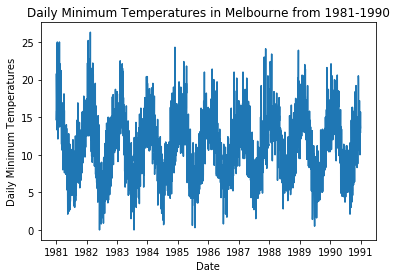

In [19]:
#Plotting our data for visual interpretation:

plt.xlabel('Date')
plt.ylabel('Daily Minimum Temperatures')
plt.plot(data)
plt.title('Daily Minimum Temperatures in Melbourne from 1981-1990')
plt.show()

The time series has an obvious "seasonality" pattern: 

We see the "lowest possible" minimum temperaures are recorded in the mid months of each year while the "highest possible" minimum temperatures are recoded during the initial/end months of an year

However there doesn't seem to be a "trend" in the data.

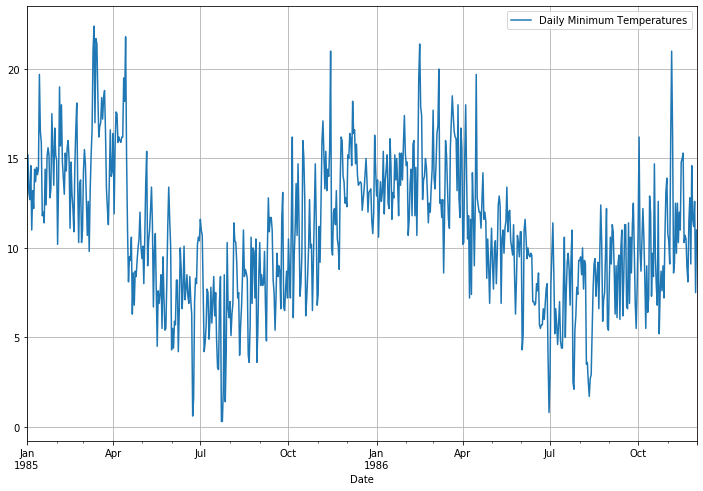

In [20]:
#Let’s take a closer look by observing some year’s data
matplotlib.rcParams['figure.figsize'] = [12.0,8.0]

start_date = datetime(1985,1,1)
end_date = datetime(1986,12,1)
data[(start_date <= data.index) & (data.index <= end_date)].plot(grid=True)

The Daily minimum temperatures seem to be decreasing each year till July and then start increasing till January - confirming the seasonality

However, let's plot the data alongside Rolling Mean and Variance to get a better picture of the underlying trend and seasonality in the data:

In [21]:
#Determine rolling statistics
rolmean = data.rolling(window=30).mean() #window size 30 denotes days, giving rolling mean at monthly level
print(rolmean)

            Daily Minimum Temperatures
Date                                  
1981-01-01                         NaN
1981-01-02                         NaN
1981-01-03                         NaN
1981-01-04                         NaN
1981-01-05                         NaN
...                                ...
1990-12-27                   14.390000
1990-12-28                   14.353333
1990-12-29                   14.313333
1990-12-30                   14.413333
1990-12-31                   14.403333

[3647 rows x 1 columns]


In [22]:
rolstd = data.rolling(window=30).std()
print(rolstd)

            Daily Minimum Temperatures
Date                                  
1981-01-01                         NaN
1981-01-02                         NaN
1981-01-03                         NaN
1981-01-04                         NaN
1981-01-05                         NaN
...                                ...
1990-12-27                    2.530824
1990-12-28                    2.534144
1990-12-29                    2.537951
1990-12-30                    2.531285
1990-12-31                    2.536422

[3647 rows x 1 columns]


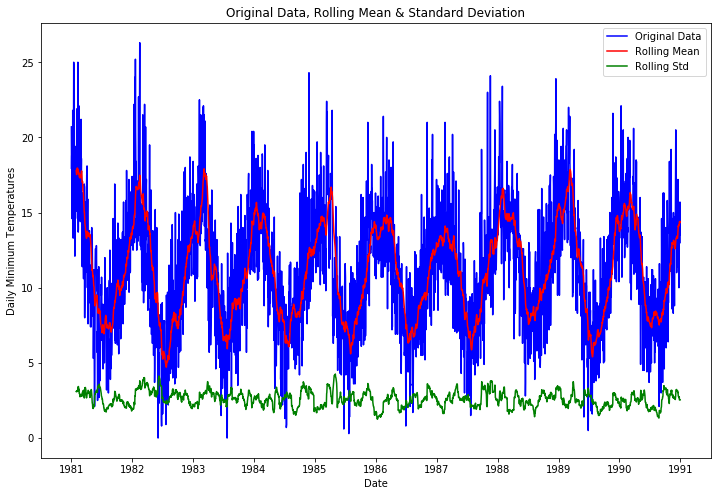

In [23]:
#Plotting rolling statistics with our data
orig = plt.plot(data, color='blue', label='Original Data')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='green', label='Rolling Std')
plt.xlabel('Date')
plt.ylabel('Daily Minimum Temperatures')
plt.legend(loc='best')
plt.title('Original Data, Rolling Mean & Standard Deviation')
plt.show(block=False)

From the above graph, we see that both the rolling mean and rolling standard deviation are fairly constant with time (without any trend/trend can be seen as a straight line parallel to x-axis).

For our time series to be stationary, we need to ensure that both the rolling statistics ie: mean & std. dev. remain time invariant or constant with time. Thus the curves for both of them have to be parallel to the x-axis, which in our case is so.

To further augment our hypothesis that the time series is stationary, let us perform the ADF Unit Root test:

The Augmented Dickey-Fuller test can be used to test for a unit root in a univariate process in the presence of serial correlation.

Notes:

The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the p-value is above a critical size, then we cannot reject that there is a unit root.

The p-values are obtained through regression surface approximation from MacKinnon 1994, but using the updated 2010 tables. If the p-value is close to significant, then the critical values should be used to judge whether to reject the null. 

    Here we assume p-value < 0.05 => Data is Stationary

In [24]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
adftest = adfuller(data['Daily Minimum Temperatures'], maxlag = 30, regression = 'ct', autolag='AIC')

dfoutput = pd.Series(adftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
for key,value in adftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                   -4.459142
p-value                           0.001759
Lags Used                        20.000000
Number of Observations Used    3626.000000
Critical Value (1%)              -3.961269
Critical Value (5%)              -3.411701
Critical Value (10%)             -3.127763
dtype: float64


As the p-value is close to 0, chances of our prediction to be random is pretty small.
We can confirm our data is fairly stationary (effect of shock will die out gradually).

    In additive form, time series Y is formed by the sum of time series components, namely, Trend, Cycle, Seasonality, Residual: 
    Y = Trend + Cycle + Seasonality + Residual

    In multiplicative form time series Y is formed by the product of time series components:
    Y = Trend * Cycle * Seasonality * Residual
    
So, is our Daily Minimum Temperatures is multiplicative or additive? 

We see that trend is a straight line for our data, while the seasonality is going up and down periodically.

This can be seen as a Additive time series hence.

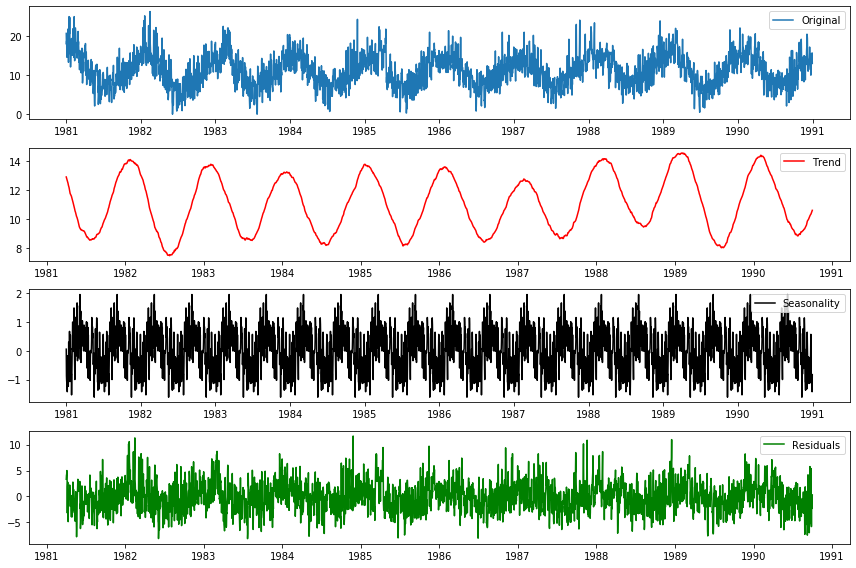

In [25]:
decomposition = seasonal_decompose(data, model = 'additive', freq=182) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(data, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend', color='red')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality', color='black')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals', color='green')
plt.legend(loc='best')

plt.tight_layout()

We shoudn't be surprised if the function returns all 3 components even though we assume that they do not exist for a particular time series data. 

In reality, these components are generated by a simple algorithm, that’s why the decomposition function cannot say a component doesn’t exist, despite the calculated value is not significant. So, you will see these three components for any time series data. 

We have to know how to read the results and decide which model (ARIMA or SARIMA) to fit the data.

We have to take a look at ACF and PACF plots, before model building.

Autocorrelation plot shows the correlation of time series data with its own lagged values. 

    For example, autocorrelation at lag=1 shows the correlation between y_t and y_t-1. At lag=2, corr(y_t, y_t-2). At lag=12 corr(y_t, y_t-12).

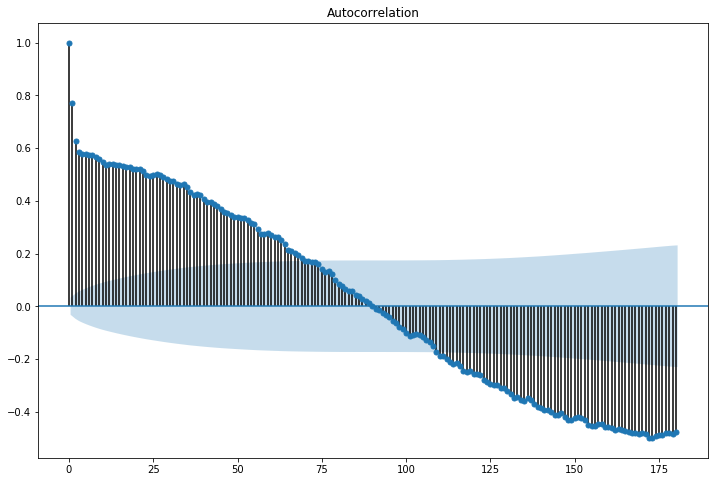

In [26]:
#AutoCorrelation Plot:
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data, lags=180)
pyplot.show()

Blue shaded area at the autocorrelation plot shows significance level. 

So, correlation coefficients within the shaded area show weak correlation at those lags and we don’t consider them significant in the analysis.

The Partial autocorrelation function (PACF) gives the partial correlation of a stationary time series with its own lagged values.

PACF removes the correlation contribution of other lags and gives the pure correlation between two lags without the effect of others.

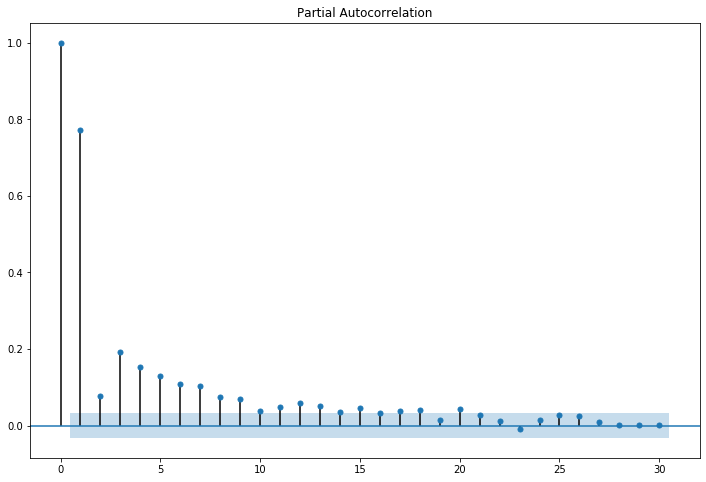

In [27]:
#Partial Auto Correlation:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data, lags=30)
pyplot.show()

We use ACF and PACF to choose a correct order for AR(p) and MA(q) components of an ARIMA model. 

    For AR order p, look at PACF plot and choose a lag value which has a significant correlation factor before correlations get insignificant. 

    For MA order q look at ACF plot and do the same. 

    We you should only get these values from the ACF and PACF plots of stationary time series.

SARIMA, Seasonal ARIMA is a special member of ARIMA family which can model seasonal component of time series data.

AR — Auto-Regressive model means time series data is regressed on its lagged values. Lagged values become independent variables, whereas time series itself becomes the dependent variable.

y = a0 + a1*y_(t-1) + a2*y_(t-2), ….., ak*y_(t-k)

The main task here is to choose how many time steps to be used as independent variables.

    PACF of stationary data has significant autocorrelation at lag=1 and the next autocorrelation at Lag=2 becomes insignificant.

    Ideally, AR order p should be 1. 

Since AR(p) and MA(q) terms interact, the initial p and q values observed from acf & pacf plots are no longer reliable and should be used as a starting point. 

We have to do parameter search on p to find the optimal value. An initial guess will help to define which values to use for a grid search. 

    In this case, p = [0–2] would be sufficient.

I — order of integration: Basically, how many times you have differenced the data. We had it once d=1. Do not forget to fit the model to not differenced data when you set parameter d=1, as the algorithm will differentiate it. If you fit model to stationary data, thenyou don't need differencing anymore. You can leave d=0. We need differencing just to make the data stationary.

MA — Moving Average model: Time series y is regressed on residuals w.

y = a0 + a1*w(1) + a2*w(2) + …. + ak*w(k)

    Look at ACF plot to determine MA order (q) of the ARIMA model. ACF suggests order q=1 for MA part of the ARIMA model. However, we should do a grid search to find an optimal model. I suggest looking at values q=[0–2]
    
Seasonal model — Seasonal features have to be added to the model together with AR and MA and it has 4 parameters (P, D, Q, s). 
Think of P, D and Q parameters being similar to AR, I and MA parameters, but only for a seasonal component of the series.

    Choose P by looking at PACF and Q by looking at ACF. The number of seasonal differences has been taken is D. Frequency of seasonal effect is defined by s.
    
P = 1 - because we have significant correlation at lag=3, however, they are not strong enough and we may not need to have an AR variable in the model. That’s why we should grid search on P = [0–2]

D = 0 - as we didn't have to difference the data

Q = 1 — as we have strong correlation at lag=12 according to ACF plot. Let’s perform grid search on parameter Q=[0–2], too.

s = 12 — seasonality frequency, every 12 months as we see both the peak and down of the graph are repeating for every 12 months 

In [28]:
#Parameter Selection for the ARIMA Time Series Model
#Using Grid Search
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [29]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:28406.40222928624
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:25220.215893191526
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:20183.026192957892


/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:19042.24287211339


/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:20086.924355389194
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:19095.943359935693
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:19265.64928712036


/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:19034.800209812984
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:24484.90501264896


/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:22373.48813501975
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:19201.926193050287


/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:17824.750542376423


/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:19048.839274559028


/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:17869.503466312002


/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:18223.598236767706


/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:17825.298432620963
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:17672.519714466915


/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:17614.556508613976
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:20144.426931016777


/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:17620.362196409318
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:17621.50928031127


/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:17613.084760277256
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:19090.68003574689


/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:17622.361852582977
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:17338.903913712747


/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:17274.897756192724
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:19849.099395110195


/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:17288.455807146267


/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:17288.4676809825


/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:17274.416413789804


/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:18794.421813480072


/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:17290.45181514755
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:17630.131605696013


/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:17574.45131683547
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:19119.110503257085


/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:17190.784157010028


/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:17574.42004742477


/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:17260.51896935342


/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:18107.132271132577


/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:17185.60126564898
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:17335.821622280455


/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:17272.74575483246
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:19080.26476894411


/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:17141.369964559486


/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:17281.17173936772


/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:17209.472924367554


/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:18076.35997442738


/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:17142.79543068119
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:17552.236685544467


/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:17493.147938912483
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:20030.153042065132


/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:17502.728595116365
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:17493.178454235254


/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:17492.04674688064


/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:18980.573423305865


/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:17504.726868232294
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:16808.27262090017


/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:16756.010501965997


/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:19114.945579110296


/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:16761.02341634996


/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:16758.914066125766


/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:16758.030545067675


/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:18118.13969085773


/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:16763.023404354753


The output of our code suggests that SARIMAX(1, 1, 1)x(0, 0, 1, 12) yields the lowest AIC value of 16756.01

We should therefore consider this to be optimal option out of all the models we have considered.

In [30]:
# Fitting the SARIMA model (can model both Seasonality and trend together unlike ARIMA which can model only trend)
mod = sm.tsa.statespace.SARIMAX(data,
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

/home/agsuser/venv/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4592      0.018     26.066      0.000       0.425       0.494
ma.L1         -1.0878      0.010   -107.941      0.000      -1.108      -1.068
ma.S.L12      -0.0050      0.017     -0.290      0.772      -0.039       0.029
sigma2         4.9761      0.148     33.639      0.000       4.686       5.266


The summary attribute that results from the output of SARIMAX returns a significant amount of information, but we’ll focus our attention on the table of coefficients. 

    The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. 
    
    The P>|z| column informs us of the significance of each feature weight. 
    
    Here, each weight has a p-value lower or close to 0.05 except for the MA component in the Seasonality of the data, so it is reasonable to retain the rest of them in our model.

When fitting seasonal ARIMA models (and any other models for that matter), it is important to run model diagnostics to ensure that none of the assumptions made by the model have been violated. 

The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

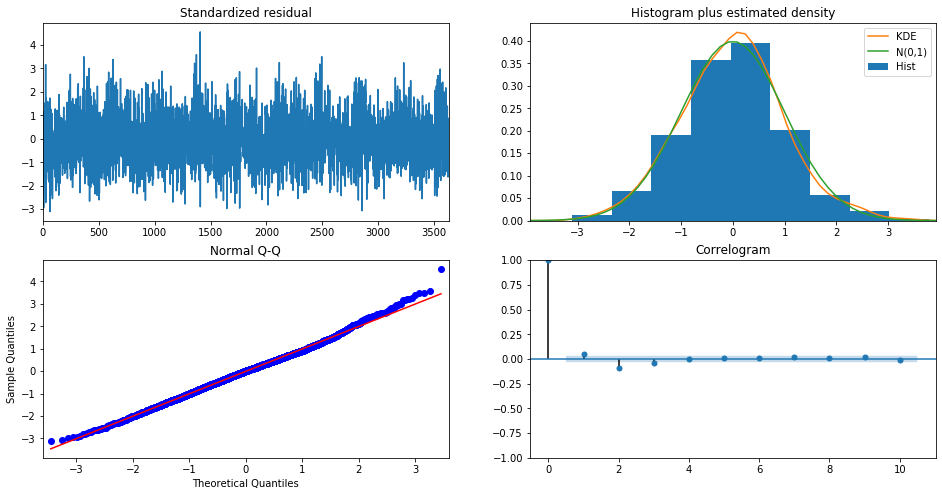

In [31]:
#Model Diagnostics 
results.plot_diagnostics(figsize=(16, 8))
plt.show()

Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:

    In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

    The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

    The residuals over time (top left plot) don’t display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

Those observations lead us to conclude that our model produces a satisfactory fit that could help us understand our time series data and forecast future values.

Although we have a satisfactory fit, some parameters of our seasonal ARIMA model could be changed to improve our model fit. For example, our grid search only considered a restricted set of parameter combinations, so we may find better models if we widened the grid search.


We have obtained a model for our time series that can now be used to produce forecasts. We start by comparing predicted values to real values of the time series, which will help us understand the accuracy of our forecasts. 

    The get_prediction() and conf_int() attributes allow us to obtain the values and associated confidence intervals for forecasts of the time series.
    
    The dynamic=False argument ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.

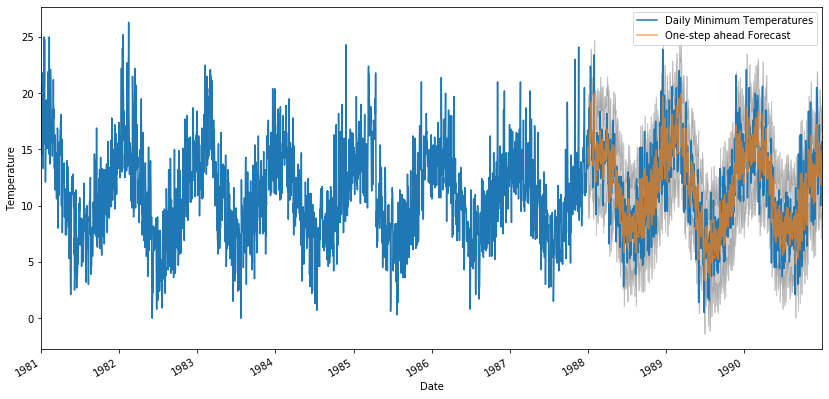

In [32]:
#Validating forecasts
#One-step ahead forecast
pred = results.get_prediction(start=pd.to_datetime('1988-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = data['1981':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
plt.legend()

plt.show()

Overall, our forecasts aligned with the true values well

It is also useful to quantify the accuracy of our forecasts. 

We will use both MSE (Mean Squared Error) and RMSE (Root Mean Squared Error), which summarizes the average error of our forecasts. 

For each predicted value, we compute its distance to the true value and square the result. The results need to be squared so that positive/negative differences do not cancel each other out when we compute the overall mean.

To which we apply the sqrt to get the rmse

In [33]:
forecasted_temp = pred.predicted_mean

Orig_temp = data['1988-01-01':]
Orig_temp = Orig_temp.values
Orig_temp = Orig_temp.reshape(Orig_temp.shape[0],)

from sklearn.metrics import mean_squared_error
from math import sqrt

mse = mean_squared_error(Orig_temp, forecasted_temp)
rmse = sqrt(mse)

print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 5.28
The Root Mean Squared Error of our forecasts is 2.3


Our model was able to forecast the average daily minimum temperatures in the test set within 2.3 degrees of the real temperatures

However, a better representation of our true predictive power can be obtained using dynamic forecasts. In this case, we only use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points.

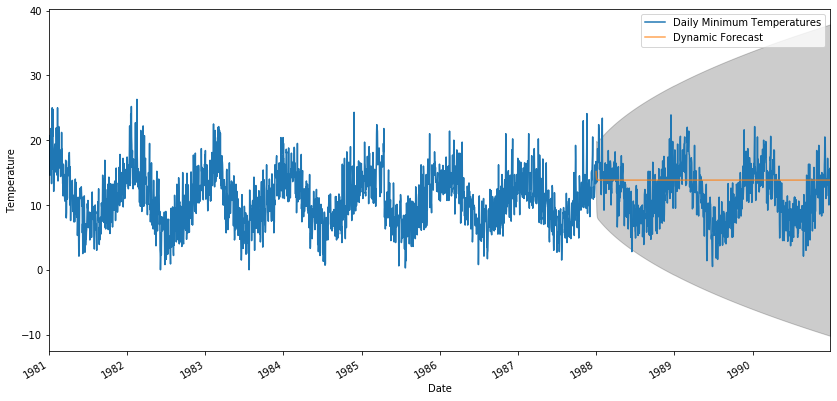

In [34]:
#Dynamic Forecasts
pred_dynamic = results.get_prediction(start=pd.to_datetime('1988-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

ax = data['1981':].plot(label='observed')
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature')

plt.legend()
plt.show()

Once again, we quantify the predictive performance of our forecasts by computing the RMSE: 

In [35]:
forecasted_temp = pred_dynamic.predicted_mean

mse = mean_squared_error(Orig_temp, forecasted_temp)
rmse = sqrt(mse)

print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 20.82
The Root Mean Squared Error of our forecasts is 4.56


The predicted values obtained from the dynamic forecasts yield an RMSE of 4.56. This is 2 degrees higher than the one-step ahead, which is to be expected given that we are relying on less historical data from the time series.

Both the one-step ahead and dynamic forecasts confirm that this time series model is valid. 

Implementing LSTM:
    
This is a Univariate Time Series data, we model it as a univariate regression-type problem,

X(t) denotes the number of airline passengers in month t. Then:

X(t) = f[X(t−1),Θ]

which we aim to solve using a simple LSTM neural network.

X(t−1) - denotes number of passengers in the previous month (time step)

Θ - refers to all the other model parameters, including LSTM hyperparameters.

Note: The predicted new value at time step (t) is written as Y


In [36]:
import math

Before we do anything, it is a good idea to fix the random number seed to ensure our results are reproducible.

In [37]:
# fix random seed for reproducibility
np.random.seed(7)

In [38]:
data = data.reset_index()

In [39]:
data = data[['Daily Minimum Temperatures']]

In [40]:
data.head()

,Daily Minimum Temperatures
0,20.7
1,17.9
2,18.8
3,14.6
4,15.8


In [41]:
#Converting the dataframe object to a numpy array
dataset = data.values

In [42]:
#convert the integer values to floating point values
dataset = dataset.astype('float32')

Split Into Samples - Not needed in this case as our sample size is small enough for the LSTM to work normally

We could also consider de-trending the time series and applying further "cleaning" techniques, which would be a prerequisite e.g. in an ARIMA setting.

However, for LSTM the trend and seasonal components would be useful to identify the non-linear properties in a better way.

The only transformations we'll be doing are:

    1.Scale data to the (0,1) interval for increased numerical stability. (Data Normalization)

    2.Create label so we have one column as response (called Y in the code) and another one as predictor variable (called X in the code).

In [43]:
#Normalizing the Data
from sklearn.preprocessing import MinMaxScaler

# We apply the MinMax scaler from sklearn
# to normalize data in the (0, 1) interval.
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(dataset)

# Print a few values
dataset[0:5]

array([[0.7870723],
       [0.6806084],
       [0.7148289],
       [0.5551331],
       [0.6007605]], dtype=float32)

Splitting the data to Train and Test: (Can also use Cross-Validation for better accuracy)

With time series data, the sequence of values is important. A simple method that we can use is to split the ordered dataset into train and test datasets. The code below calculates the index of the split point and separates the data into the training datasets with 67% of the observations that we can use to train our model, leaving the remaining 33% for testing the model.

I observed this way of splitting gave me better results compared to using train_test_split from sklearn


In [44]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train_X, test_X = dataset[0:train_size], dataset[train_size:len(dataset)]

In [45]:
print(len(train_X), len(test_X))

2443 1204


We create labels for our train and test arrays using the below function:

The function takes two arguments: the dataset, which is a NumPy array that we want to convert into a dataset, and the look_back, which is the number of previous time steps to use as input variables to predict the next time period — in this case defaulted to 1.

This default will create a dataset where X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).

Note that the last row is being skipped here as there is no (t+1) time stamp value for the last row - An alternative could be filling it with the mean value of the array.


In [46]:
#Creating the labels for the Train and Test arrays
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [47]:
# reshape into X=t and Y=t+1
look_back = 1
train_X, train_Y = create_dataset(train_X, look_back)
test_X, test_Y = create_dataset(test_X, look_back)

In [48]:
print(len(train_X),len(train_Y),len(test_X),len(test_Y))

2442 2442 1203 1203


In [49]:
train_X

array([[0.7870723 ],
       [0.6806084 ],
       [0.7148289 ],
       ...,
       [0.2661597 ],
       [0.34220535],
       [0.38783273]], dtype=float32)

In [50]:
train_Y

array([0.6806084 , 0.7148289 , 0.5551331 , ..., 0.34220535, 0.38783273,
       0.25855514], dtype=float32)

In [51]:
test_X

array([[0.35361218],
       [0.3726236 ],
       [0.40684414],
       ...,
       [0.5171103 ],
       [0.51330805],
       [0.5969582 ]], dtype=float32)

In [52]:
test_Y

array([0.3726236 , 0.40684414, 0.29657796, ..., 0.51330805, 0.5969582 ,
       0.4942966 ], dtype=float32)

Transforms shape of data suitable for LSTM:

LSTMs in Keras are typically used on 3d data (batch_size, timesteps, features)

batch_size(default: None) Can be any size, as long as it is the same for your inputs and targets.

When you're dealing with LSTMs, the batch_size is the number of sequences, not the length of the sequence.

Samples - This is the len(dataX), or the amount of data points you have.

Time steps - This is equivalent to the amount of time steps you run your recurrent neural network. If you want your network to have memory of 60 characters, this number should be 60.

Features - this is the amount of features in every time step. If you are processing pictures, this is the amount of pixels. In this case you seem to have 1 feature per time step.

Our goal is to reshape the INPUT into 3D format as expected by LSTMs:

[batch_size, timesteps, features]

Output Shape of an LSTM is a 2D array: [batch_size, features]

Here we have 1 sample , 86 time steps in Training set and 58 time steps in Test set with 1 feature (Number of Air Passengers in a month)


In [53]:
print("Current data shape:")
print(train_X.shape,train_Y.shape,test_X.shape,test_Y.shape)

Current data shape:
(2442, 1) (2442,) (1203, 1) (1203,)


In [54]:
train_X = train_X.reshape(train_X.shape[0], 1, train_X.shape[1])

In [55]:
test_X = test_X.reshape(test_X.shape[0], 1, test_X.shape[1])

In [56]:
#Reshaped data suitable for LSTM:
print("Reshaped data suitable for LSTM:")
print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)

Reshaped data suitable for LSTM:
(2442, 1, 1) (2442,) (1203, 1, 1) (1203,)


Building the LSTM model:

First, we need to import a couple of modules from Keras:

Sequential - for initializing the neural network
LSTM - for adding the Long Short-Term Memory layer
Dense - for the output layer
Activation - for getting the neuron's output
Dropout - for adding dropout layers that prevent overfitting 

-Neural networks can learn complex patterns using layers of neurons which mathematically transform the data

-The layers between the input and output are referred to as “hidden layers”

-A neural network can learn relationships between the features that other algorithms cannot easily discover

-An artificial neuron (also referred to as a perceptron) is a mathematical function. It takes one or more inputs that are multiplied by values called “weights” and added together.

-An activation function is a non-linear function applied by a neuron to introduce non-linear properties in the network.

Before fitting a model, we need to choose the Optimal Hyperparameters:
    
    One way is to use Grid Search: Here we will be optimising only the Batch size, Epochs and the Learning rate for now
    
    
    Using only 4 neurons, hence using the default activation function of Keras (tanh activation) - values in -1 to 1 range, hence Vanishing Gradient problem will be less

In [57]:
# Loading the required libraries:
# We'll be using the Tensorflow backend (default):

from keras.models import Sequential  #initialize the network
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout

from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from keras.optimizers import adam
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras.constraints import maxnorm

Using TensorFlow backend.


In [62]:
# Function to create model, required for KerasRegressor

def create_model(learn_rate=0.001):
    model = Sequential()
    
    model.add(LSTM(6, batch_input_shape = (None, train_X.shape[1], train_X.shape[2]), return_sequences=True))
    model.add(LSTM(4, return_sequences=True))
    model.add(LSTM(2, return_sequences=False))
        
    model.add(Dense(1))
    
    optimizer = adam(lr=learn_rate)
    
    model.compile(loss = "mse", optimizer = optimizer)
    model.summary()
    return model

In [63]:
# create model
model = KerasRegressor(build_fn=create_model, verbose=0)

In [64]:
# define the grid search parameters

batch_size = [128, 256, 365]
epochs = [150, 250]

learn_rate = [0.001, 0.01]
 
param_grid = dict(batch_size=batch_size, epochs=epochs,learn_rate=learn_rate)


grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs = -1, cv=5)
grid_result = grid.fit(train_X, train_Y)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1, 6)              192       
_________________________________________________________________
lstm_5 (LSTM)                (None, 1, 4)              176       
_________________________________________________________________
lstm_6 (LSTM)                (None, 2)                 56        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 427
Trainable params: 427
Non-trainable params: 0
_________________________________________________________________


In [65]:
# summarize results:

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.009923 using {'batch_size': 128, 'epochs': 250, 'learn_rate': 0.001}
-0.009965 (0.000722) with: {'batch_size': 128, 'epochs': 150, 'learn_rate': 0.001}
-0.010140 (0.001007) with: {'batch_size': 128, 'epochs': 150, 'learn_rate': 0.01}
-0.009923 (0.000706) with: {'batch_size': 128, 'epochs': 250, 'learn_rate': 0.001}
-0.010120 (0.000926) with: {'batch_size': 128, 'epochs': 250, 'learn_rate': 0.01}
-0.009991 (0.000699) with: {'batch_size': 256, 'epochs': 150, 'learn_rate': 0.001}
-0.010288 (0.000938) with: {'batch_size': 256, 'epochs': 150, 'learn_rate': 0.01}
-0.010031 (0.000759) with: {'batch_size': 256, 'epochs': 250, 'learn_rate': 0.001}
-0.010043 (0.000799) with: {'batch_size': 256, 'epochs': 250, 'learn_rate': 0.01}
-0.010198 (0.000887) with: {'batch_size': 365, 'epochs': 150, 'learn_rate': 0.001}
-0.010004 (0.000739) with: {'batch_size': 365, 'epochs': 150, 'learn_rate': 0.01}
-0.009970 (0.000721) with: {'batch_size': 365, 'epochs': 250, 'learn_rate': 0.001}
-0.010043 (0.0

Best: -0.009923 using {'batch_size': 128, 'epochs': 250, 'learn_rate': 0.001}

In [66]:
# Function to create model, required for KerasRegressor

def create_model2(optimizer = 'Adam', loss = 'mean_absolute_error'):
    model = Sequential()
    
    model.add(LSTM(6, batch_input_shape = (None, train_X.shape[1], train_X.shape[2]), return_sequences=True))
    model.add(LSTM(4, return_sequences=True))
    model.add(LSTM(2, return_sequences=False))
        
    model.add(Dense(1))
      
    model.compile(loss = loss, optimizer = optimizer, metrics = [loss])
    model.summary()
    return model

In [67]:
# create model
# Taking the epochs=250 and batch_size=128 
# based on above grid serach results
# Now we find the best optimizer and loss function for our problem using Grid Search again
model2 = KerasRegressor(build_fn=create_model2, verbose=0, epochs = 250, batch_size = 128)

In [70]:
# define the grid search parameters

optimizer = ['SGD', 'Adam', 'adadelta']
loss = ['mean_squared_error' , 'mean_absolute_error']

param_grid = dict(optimizer = optimizer, loss = loss)


grid = GridSearchCV(estimator=model2, param_grid=param_grid, n_jobs = -1, cv=5)
grid_result = grid.fit(train_X, train_Y)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 1, 6)              192       
_________________________________________________________________
lstm_11 (LSTM)               (None, 1, 4)              176       
_________________________________________________________________
lstm_12 (LSTM)               (None, 2)                 56        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 3         
Total params: 427
Trainable params: 427
Non-trainable params: 0
_________________________________________________________________


In [71]:
# summarize results:

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.009968 using {'loss': 'mean_squared_error', 'optimizer': 'Adam'}
-0.024967 (0.005059) with: {'loss': 'mean_squared_error', 'optimizer': 'SGD'}
-0.009968 (0.000735) with: {'loss': 'mean_squared_error', 'optimizer': 'Adam'}
-0.010013 (0.000906) with: {'loss': 'mean_squared_error', 'optimizer': 'adadelta'}
-0.126763 (0.013589) with: {'loss': 'mean_absolute_error', 'optimizer': 'SGD'}
-0.077397 (0.003185) with: {'loss': 'mean_absolute_error', 'optimizer': 'Adam'}
-0.077728 (0.003655) with: {'loss': 'mean_absolute_error', 'optimizer': 'adadelta'}


Now that we have identified the best hyper parameters, we fit our model and make predictions:
    
    Epochs: 250
    Batch_size: 128
    learn_rate: 0.001 (which is also the default "lr" for adam optimizer)
    
    Optimizer: "adam"
    Loss function: "mean_squared_error"
    
Best: -0.009968 using {'loss': 'mean_squared_error', 'optimizer': 'Adam'}

In [72]:
from keras.callbacks import TensorBoard
tb = TensorBoard(log_dir='./logs', histogram_freq=10, write_graph=True, write_images=True)

In [73]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min')

In [74]:
final_model = Sequential()
    
final_model.add(LSTM(6, batch_input_shape = (None, train_X.shape[1], train_X.shape[2]), return_sequences=True))
final_model.add(LSTM(4, return_sequences=True))
final_model.add(LSTM(2, return_sequences=False)) 
        
final_model.add(Dense(1))
    
final_model.compile(loss = "mse", optimizer = 'adam' , metrics = ['mse'])
final_model.summary()

history = final_model.fit(train_X, train_Y, epochs = 250, validation_data = (test_X, test_Y), batch_size = 128, verbose = 2, callbacks=[tb , es])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 1, 6)              192       
_________________________________________________________________
lstm_14 (LSTM)               (None, 1, 4)              176       
_________________________________________________________________
lstm_15 (LSTM)               (None, 2)                 56        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 3         
Total params: 427
Trainable params: 427
Non-trainable params: 0
_________________________________________________________________
Train on 2442 samples, validate on 1203 samples
Epoch 1/250
 - 1s - loss: 0.1861 - mse: 0.1861 - val_loss: 0.1939 - val_mse: 0.1939
Epoch 2/250
 - 0s - loss: 0.1632 - mse: 0.1632 - val_loss: 0.1696 - val_mse: 0.1696
Epoch 3/250
 - 0s - loss: 0.1408 - mse

Note: 
    
    Accuracy is not defined for regression problems.
    
    Accuracy is just the fraction of correctly classified examples, which is always the fraction where label == prediction is true.
    
    For regression this makes no sense as the chance that the predicted value is exactly the same as the label is very small. The accuracy in Keras is never mean absolute error
    
    The accuracy in Keras does not change if its regression or classification, its always fraction where label == predicted.
    
    that's why accuracy makes no sense for regression.

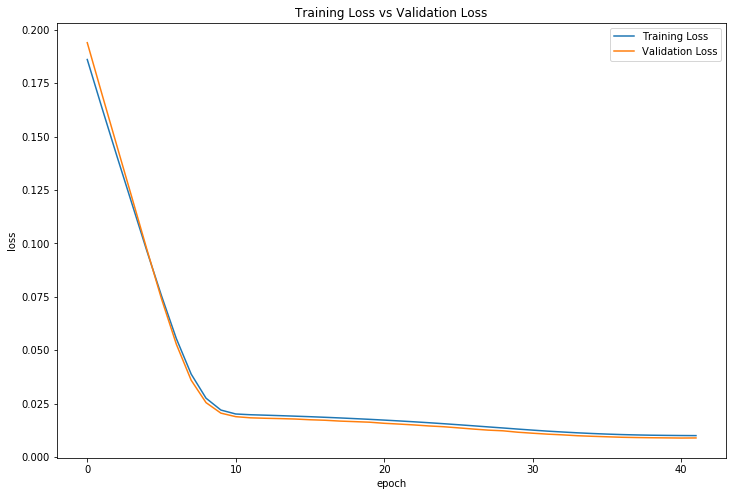

In [75]:
# Plotting training and validation loss using the above results:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

We see that Grid Search did give us the optimal hyperparameters.

It is worth noting that the number of epochs increase as we decrease the learning rate (which makes sense as the weights get updated slowly this way)

Our model stopped learning after 40 epochs with a Validation loss of less than 1%

We acheived similar results when lr=0.01 but with a fewer number of epochs but the loss curves/learning were not gradual

Hence we proceed with these results and make predictions:

Predictions and Model Evaluations:

We have to estimate the performance of the model on the train and test datasets. This will give us a point of comparison for new models.

Note that we invert the predictions before calculating error scores to ensure that performance is reported in the same units as the original data (daily min. temperatures).


In [76]:
# LSTM Prediction:
trainPredict = final_model.predict(train_X)
testPredict = final_model.predict(test_X)

In [77]:
# inverting the predictions to original scale
trainPredict = scaler.inverse_transform(trainPredict)
train_Y = scaler.inverse_transform([train_Y])

testPredict = scaler.inverse_transform(testPredict)
test_Y = scaler.inverse_transform([test_Y])

Now that we have the labels of both Training and Test sets along with their LSTM predictions in the Original Scale

We will calculate the Regression metrics using the Root Mean Squared Error (this gives the error value in terms of the original scale of the data unlike the Mean Squared Error)

In [78]:
print(train_Y.shape,trainPredict.shape,test_Y.shape,testPredict.shape)

(1, 2442) (2442, 1) (1, 1203) (1203, 1)


In [79]:
train_Y = train_Y.reshape(train_Y.shape[1], train_Y.shape[0])
test_Y = test_Y.reshape(test_Y.shape[1], test_Y.shape[0])
print(train_Y.shape,trainPredict.shape,test_Y.shape,testPredict.shape)

(2442, 1) (2442, 1) (1203, 1) (1203, 1)


In [80]:
from sklearn.metrics import mean_squared_error
from math import sqrt

training_Error = sqrt(mean_squared_error(train_Y, trainPredict))
print('Train Score: %.2f RMSE' % (training_Error))

test_Error = sqrt(mean_squared_error(test_Y, testPredict))
print('Test Score: %.2f RMSE' % (test_Error))

Train Score: 2.63 RMSE
Test Score: 2.48 RMSE


Plotting original data, predictions and forecast:

To get a visual indication of the skill of the model

Because of the way dataset is prepared, we must shift the predictions so that they align on the x-axis with the original dataset. Once prepared, the data is plotted


(3647, 1) (3647, 1) (3647, 1)


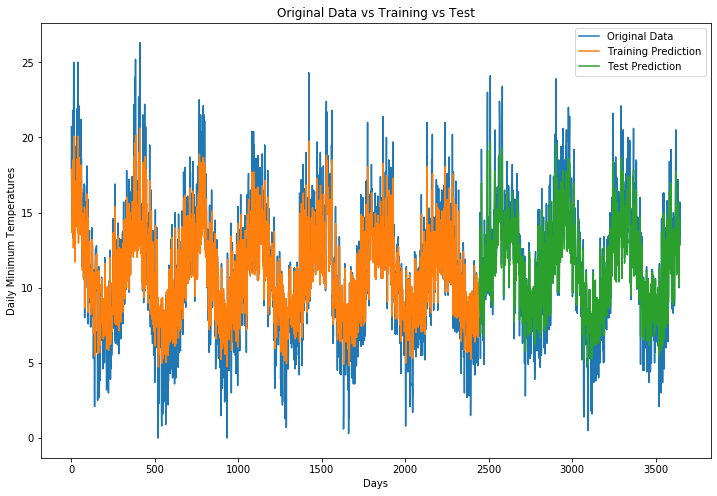

In [81]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset) #returns a new array with same shape and type as of "dataset"
trainPredictPlot[:] = np.nan  #replaces the dataset with null values
trainPredictPlot[look_back:len(trainPredict)+look_back] = trainPredict 

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:] = np.nan
testPredictPlot[len(trainPredict)+(look_back):len(dataset)-1] = testPredict

print(dataset.shape, trainPredictPlot.shape, testPredictPlot.shape)

# plotting the Original data, Training and Test predictions
plt.plot(scaler.inverse_transform(dataset), label = 'Original Data')
plt.plot(trainPredictPlot, label = 'Training Prediction')
plt.plot(testPredictPlot, label = 'Test Prediction')
plt.legend(loc='best')
plt.xlabel('Days')
plt.ylabel('Daily Minimum Temperatures')
plt.title('Original Data vs Training vs Test')
plt.show()

We now use k-fold Cross Validation to validate our results.

Using k = 5 splits on our intial data that hasn't been split into test and train, but has been normalised to 0 to 1 scale.

In [82]:
dataset[0:5]

array([[0.7870723],
       [0.6806084],
       [0.7148289],
       [0.5551331],
       [0.6007605]], dtype=float32)

Observations: 1219
Training Observations: 612
Testing Observations: 607
Observations: 1826
Training Observations: 1219
Testing Observations: 607
Observations: 2433
Training Observations: 1826
Testing Observations: 607
Observations: 3040
Training Observations: 2433
Testing Observations: 607
Observations: 3647
Training Observations: 3040
Testing Observations: 607


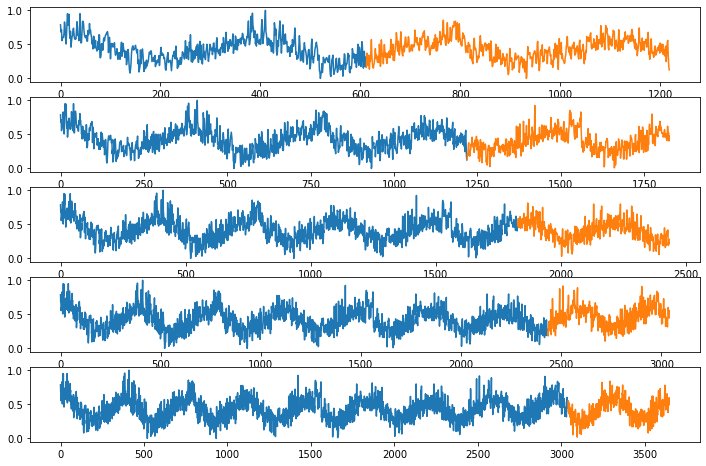

In [83]:
#K fold Cross validation for model evaluation:
from sklearn.model_selection import TimeSeriesSplit
splits = TimeSeriesSplit(n_splits=5)

X = dataset

plt.figure(1)
index = 1

for train_index, test_index in splits.split(X):
    
    train = X[train_index]
    test = X[test_index]
    
    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))
    
    plt.subplot(510 + index)
    plt.plot(train)
    plt.plot([None for i in train] + [x for x in test])
    index += 1
    
plt.show()


Split-1
612 607
Length of Taining and Test Sets along with their labels:
611 611 606 606
Current data shape:
(611, 1) (611,) (606, 1) (606,)
Reshaped data suitable for LSTM:
(611, 1, 1) (611,) (606, 1, 1) (606,)
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 1, 6)              192       
_________________________________________________________________
lstm_32 (LSTM)               (None, 1, 4)              176       
_________________________________________________________________
lstm_33 (LSTM)               (None, 2)                 56        
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 3         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 2         
Total params: 429
Trainable params: 429

Epoch 83/250
 - 0s - loss: 0.0150 - mse: 0.0150 - val_loss: 0.0116 - val_mse: 0.0116
Epoch 84/250
 - 0s - loss: 0.0147 - mse: 0.0147 - val_loss: 0.0115 - val_mse: 0.0115
Epoch 85/250
 - 0s - loss: 0.0144 - mse: 0.0144 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 86/250
 - 0s - loss: 0.0141 - mse: 0.0141 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 87/250
 - 0s - loss: 0.0139 - mse: 0.0139 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 88/250
 - 0s - loss: 0.0136 - mse: 0.0136 - val_loss: 0.0109 - val_mse: 0.0109
Epoch 89/250
 - 0s - loss: 0.0133 - mse: 0.0133 - val_loss: 0.0108 - val_mse: 0.0108
Epoch 90/250
 - 0s - loss: 0.0131 - mse: 0.0131 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 91/250
 - 0s - loss: 0.0129 - mse: 0.0129 - val_loss: 0.0106 - val_mse: 0.0106
Epoch 92/250
 - 0s - loss: 0.0127 - mse: 0.0127 - val_loss: 0.0105 - val_mse: 0.0105
Epoch 93/250
 - 0s - loss: 0.0125 - mse: 0.0125 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 94/250
 - 0s - loss: 0.0123 - mse: 0.0123 - val_loss: 0.010

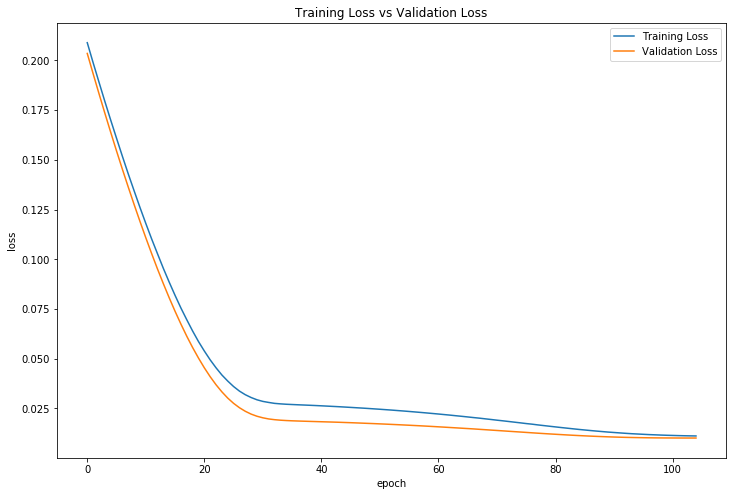

(1, 611) (611, 1) (1, 606) (606, 1)
(611, 1) (611, 1) (606, 1) (606, 1)
Train Score: 2.77 RMSE
Test Score: 2.64 RMSE


Split-2
1219 607
Length of Taining and Test Sets along with their labels:
1218 1218 606 606
Current data shape:
(1218, 1) (1218,) (606, 1) (606,)
Reshaped data suitable for LSTM:
(1218, 1, 1) (1218,) (606, 1, 1) (606,)
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 1, 6)              192       
_________________________________________________________________
lstm_35 (LSTM)               (None, 1, 4)              176       
_________________________________________________________________
lstm_36 (LSTM)               (None, 2)                 56        
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 3         
_____________________________________________

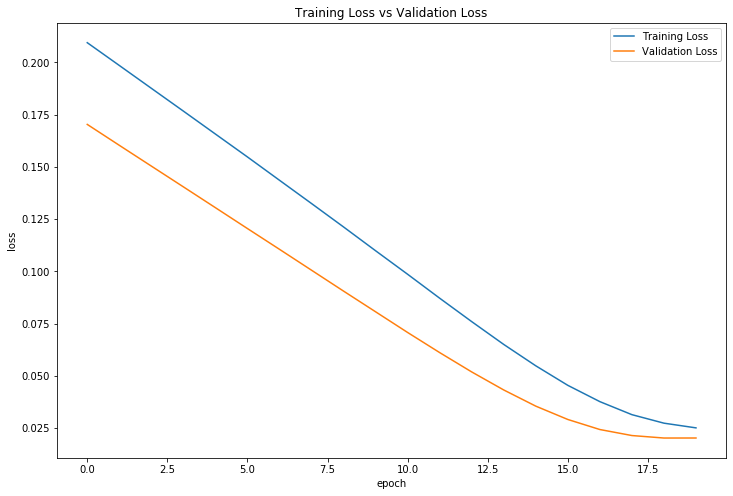

(1, 1218) (1218, 1) (1, 606) (606, 1)
(1218, 1) (1218, 1) (606, 1) (606, 1)
Train Score: 4.10 RMSE
Test Score: 3.74 RMSE


Split-3
1826 607
Length of Taining and Test Sets along with their labels:
1825 1825 606 606
Current data shape:
(1825, 1) (1825,) (606, 1) (606,)
Reshaped data suitable for LSTM:
(1825, 1, 1) (1825,) (606, 1, 1) (606,)
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (None, 1, 6)              192       
_________________________________________________________________
lstm_38 (LSTM)               (None, 1, 4)              176       
_________________________________________________________________
lstm_39 (LSTM)               (None, 2)                 56        
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 3         
_________________________________________

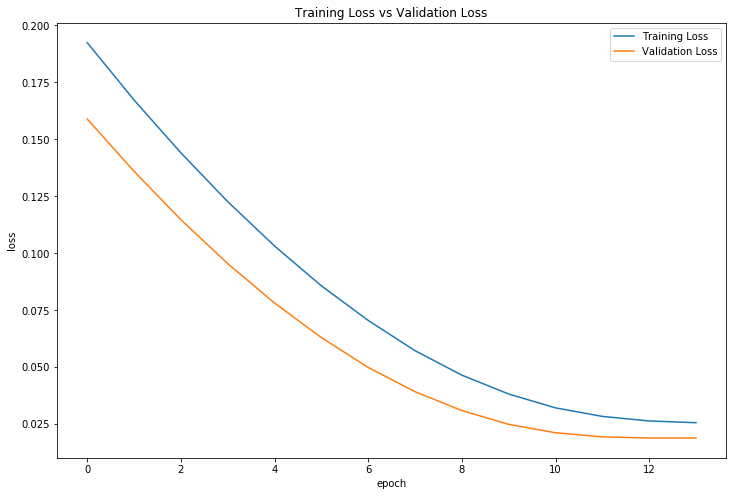

(1, 1825) (1825, 1) (1, 606) (606, 1)
(1825, 1) (1825, 1) (606, 1) (606, 1)
Train Score: 4.19 RMSE
Test Score: 3.62 RMSE


Split-4
2433 607
Length of Taining and Test Sets along with their labels:
2432 2432 606 606
Current data shape:
(2432, 1) (2432,) (606, 1) (606,)
Reshaped data suitable for LSTM:
(2432, 1, 1) (2432,) (606, 1, 1) (606,)
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_40 (LSTM)               (None, 1, 6)              192       
_________________________________________________________________
lstm_41 (LSTM)               (None, 1, 4)              176       
_________________________________________________________________
lstm_42 (LSTM)               (None, 2)                 56        
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 3         
_________________________________________

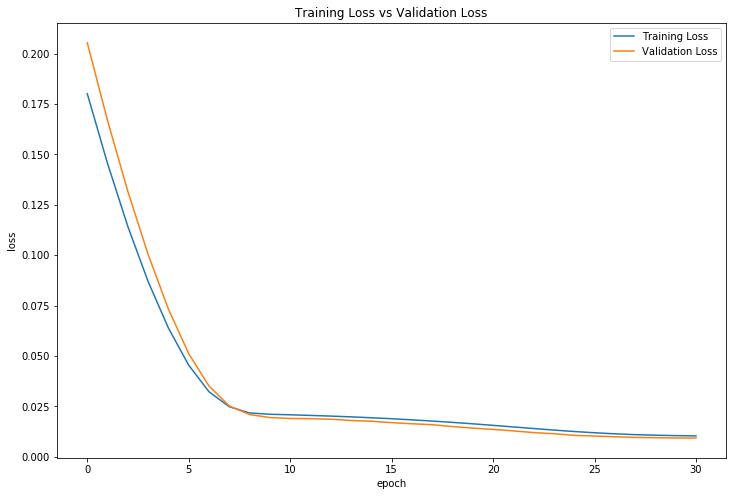

(1, 2432) (2432, 1) (1, 606) (606, 1)
(2432, 1) (2432, 1) (606, 1) (606, 1)
Train Score: 2.66 RMSE
Test Score: 2.53 RMSE


Split-5
3040 607
Length of Taining and Test Sets along with their labels:
3039 3039 606 606
Current data shape:
(3039, 1) (3039,) (606, 1) (606,)
Reshaped data suitable for LSTM:
(3039, 1, 1) (3039,) (606, 1, 1) (606,)
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_43 (LSTM)               (None, 1, 6)              192       
_________________________________________________________________
lstm_44 (LSTM)               (None, 1, 4)              176       
_________________________________________________________________
lstm_45 (LSTM)               (None, 2)                 56        
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 3         
_________________________________________

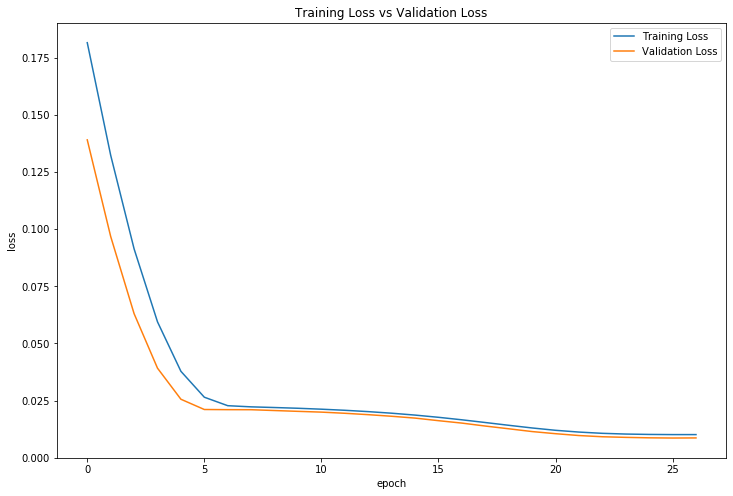

(1, 3039) (3039, 1) (1, 606) (606, 1)
(3039, 1) (3039, 1) (606, 1) (606, 1)
Train Score: 2.64 RMSE
Test Score: 2.45 RMSE




In [85]:
#Cross Validation on the model(with it's hyper parameter values) we used for prediction:
#k = 5

from sklearn.metrics import mean_squared_error
from math import sqrt

splits = TimeSeriesSplit(n_splits=5)
index = 1

for train_index, test_index in splits.split(X):
    
    print(f'Split-{index}') 
    
    train_X = X[train_index]
    test_X = X[test_index]
    
    print(len(train_X), len(test_X))
    
    def create_dataset(X, look_back=1):
        dataX, dataY = [], []
        for i in range(len(X)-1):
            a = X[i:(i+look_back), 0]
            dataX.append(a)
            dataY.append(X[i + look_back, 0])
        return np.array(dataX), np.array(dataY)

    # reshape into X=t and Y=t+1
    look_back = 1
    train_X, train_Y = create_dataset(train_X, look_back)
    test_X, test_Y = create_dataset(test_X, look_back)
    
    print("Length of Taining and Test Sets along with their labels:")
    print(len(train_X),len(train_Y),len(test_X),len(test_Y))
    
    print("Current data shape:")
    print(train_X.shape,train_Y.shape,test_X.shape,test_Y.shape)
    
    train_X = train_X.reshape(train_X.shape[0], 1, train_X.shape[1])
    test_X = test_X.reshape(test_X.shape[0], 1, test_X.shape[1])
    
    #Reshaped data suitable for LSTM:
    print("Reshaped data suitable for LSTM:")
    print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)
    
    model = Sequential()
    
    model.add(LSTM(6, batch_input_shape = (None, train_X.shape[1], train_X.shape[2]), return_sequences=True))
    model.add(LSTM(4, return_sequences=True))
    model.add(LSTM(2, return_sequences=False))    
    model.add(Dense(1))
        
    model.add(Dense(1))
    
        
    model.compile(loss = "mse", optimizer = "adam", metrics = ['mse'])
    model.summary()
    
    history = model.fit(train_X, train_Y, epochs = 250, validation_data = (test_X, test_Y), batch_size = 128, verbose = 2, callbacks=[es])

    index += 1
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Training Loss vs Validation Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
    plt.show()
    
    # LSTM Prediction:
    trainPredict = model.predict(train_X)
    testPredict = model.predict(test_X)
    
    # inverting the predictions to original scale
    trainPredict = scaler.inverse_transform(trainPredict)
    train_Y = scaler.inverse_transform([train_Y])

    testPredict = scaler.inverse_transform(testPredict)
    test_Y = scaler.inverse_transform([test_Y])
    
    print(train_Y.shape, trainPredict.shape, test_Y.shape, testPredict.shape)
    
    train_Y = train_Y.reshape(train_Y.shape[1], train_Y.shape[0])
    test_Y = test_Y.reshape(test_Y.shape[1], test_Y.shape[0])

    print(train_Y.shape, trainPredict.shape, test_Y.shape, testPredict.shape)
    
    #Calculating RMSE:

    training_Error = sqrt(mean_squared_error(train_Y, trainPredict))
    print('Train Score: %.2f RMSE' % (training_Error))

    test_Error = sqrt(mean_squared_error(test_Y, testPredict))
    print('Test Score: %.2f RMSE' % (test_Error))
    
    print("\n")

We see that the Validation results are not varying too much from our Model predictions

Now we check for k = 10

Split-1
337 331
Length of Taining and Test Sets along with their labels:
336 336 330 330
Current data shape:
(336, 1) (336,) (330, 1) (330,)
Reshaped data suitable for LSTM:
(336, 1, 1) (336,) (330, 1, 1) (330,)
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_46 (LSTM)               (None, 1, 6)              192       
_________________________________________________________________
lstm_47 (LSTM)               (None, 1, 4)              176       
_________________________________________________________________
lstm_48 (LSTM)               (None, 2)                 56        
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 3         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 2         
Total params: 429
Trainable params: 429

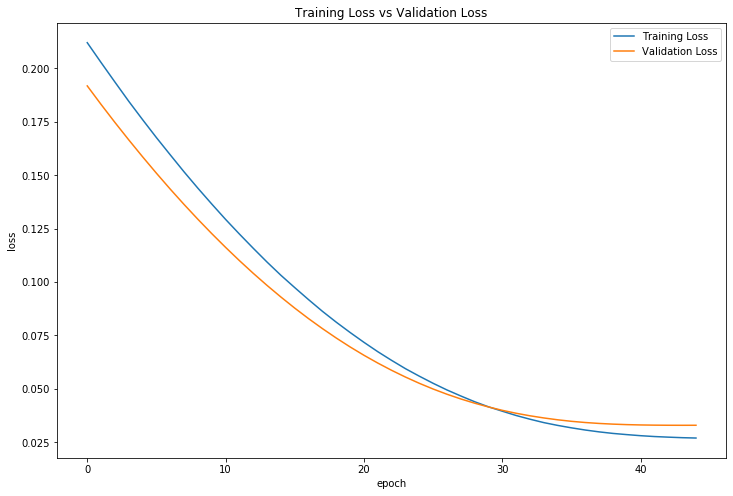

(1, 336) (336, 1) (1, 330) (330, 1)
(336, 1) (336, 1) (330, 1) (330, 1)
Train Score: 4.31 RMSE
Test Score: 4.77 RMSE


Split-2
668 331
Length of Taining and Test Sets along with their labels:
667 667 330 330
Current data shape:
(667, 1) (667,) (330, 1) (330,)
Reshaped data suitable for LSTM:
(667, 1, 1) (667,) (330, 1, 1) (330,)
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_49 (LSTM)               (None, 1, 6)              192       
_________________________________________________________________
lstm_50 (LSTM)               (None, 1, 4)              176       
_________________________________________________________________
lstm_51 (LSTM)               (None, 2)                 56        
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 3         
____________________________________________________

Epoch 82/250
 - 0s - loss: 0.0136 - mse: 0.0136 - val_loss: 0.0114 - val_mse: 0.0114
Epoch 83/250
 - 0s - loss: 0.0133 - mse: 0.0133 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 84/250
 - 0s - loss: 0.0130 - mse: 0.0130 - val_loss: 0.0109 - val_mse: 0.0109
Epoch 85/250
 - 0s - loss: 0.0127 - mse: 0.0127 - val_loss: 0.0108 - val_mse: 0.0108
Epoch 86/250
 - 0s - loss: 0.0125 - mse: 0.0125 - val_loss: 0.0106 - val_mse: 0.0106
Epoch 87/250
 - 0s - loss: 0.0123 - mse: 0.0123 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 88/250
 - 0s - loss: 0.0121 - mse: 0.0121 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 89/250
 - 0s - loss: 0.0119 - mse: 0.0119 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 90/250
 - 0s - loss: 0.0118 - mse: 0.0118 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 91/250
 - 0s - loss: 0.0117 - mse: 0.0117 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 92/250
 - 0s - loss: 0.0116 - mse: 0.0116 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 93/250
 - 0s - loss: 0.0115 - mse: 0.0115 - val_loss: 0.010

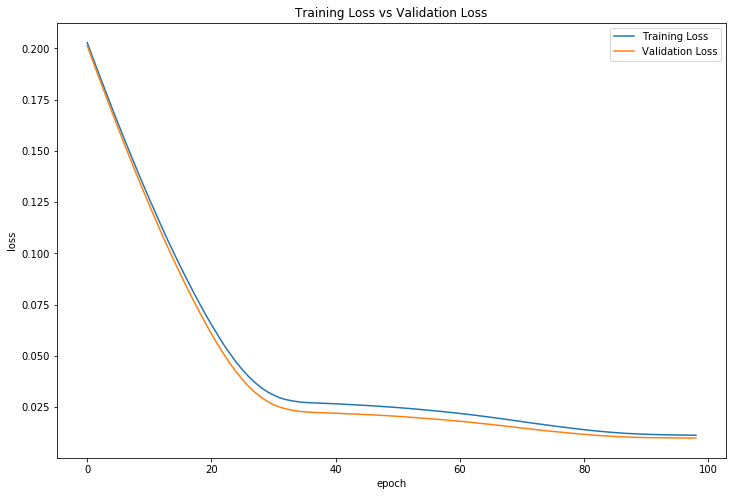

(1, 667) (667, 1) (1, 330) (330, 1)
(667, 1) (667, 1) (330, 1) (330, 1)
Train Score: 2.78 RMSE
Test Score: 2.61 RMSE


Split-3
999 331
Length of Taining and Test Sets along with their labels:
998 998 330 330
Current data shape:
(998, 1) (998,) (330, 1) (330,)
Reshaped data suitable for LSTM:
(998, 1, 1) (998,) (330, 1, 1) (330,)
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_52 (LSTM)               (None, 1, 6)              192       
_________________________________________________________________
lstm_53 (LSTM)               (None, 1, 4)              176       
_________________________________________________________________
lstm_54 (LSTM)               (None, 2)                 56        
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 3         
____________________________________________________

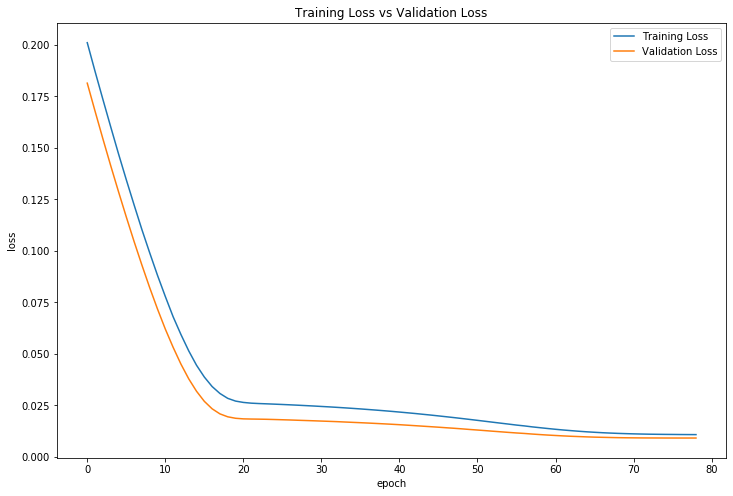

(1, 998) (998, 1) (1, 330) (330, 1)
(998, 1) (998, 1) (330, 1) (330, 1)
Train Score: 2.73 RMSE
Test Score: 2.51 RMSE


Split-4
1330 331
Length of Taining and Test Sets along with their labels:
1329 1329 330 330
Current data shape:
(1329, 1) (1329,) (330, 1) (330,)
Reshaped data suitable for LSTM:
(1329, 1, 1) (1329,) (330, 1, 1) (330,)
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_55 (LSTM)               (None, 1, 6)              192       
_________________________________________________________________
lstm_56 (LSTM)               (None, 1, 4)              176       
_________________________________________________________________
lstm_57 (LSTM)               (None, 2)                 56        
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 3         
_____________________________________________

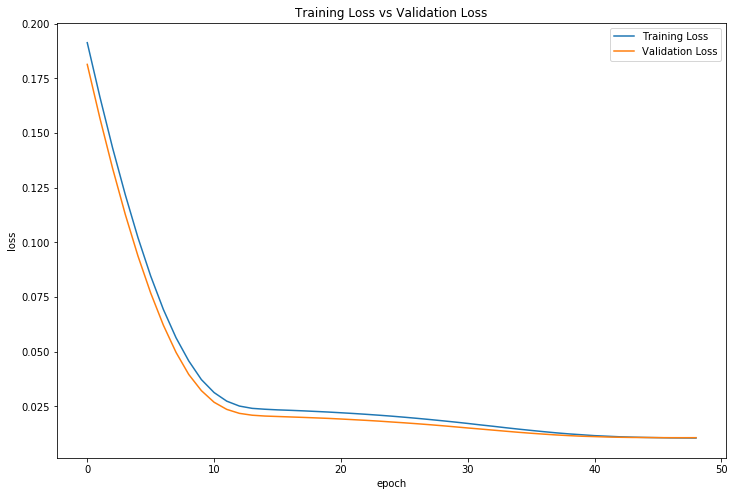

(1, 1329) (1329, 1) (1, 330) (330, 1)
(1329, 1) (1329, 1) (330, 1) (330, 1)
Train Score: 2.69 RMSE
Test Score: 2.71 RMSE


Split-5
1661 331
Length of Taining and Test Sets along with their labels:
1660 1660 330 330
Current data shape:
(1660, 1) (1660,) (330, 1) (330,)
Reshaped data suitable for LSTM:
(1660, 1, 1) (1660,) (330, 1, 1) (330,)
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_58 (LSTM)               (None, 1, 6)              192       
_________________________________________________________________
lstm_59 (LSTM)               (None, 1, 4)              176       
_________________________________________________________________
lstm_60 (LSTM)               (None, 2)                 56        
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 3         
_________________________________________

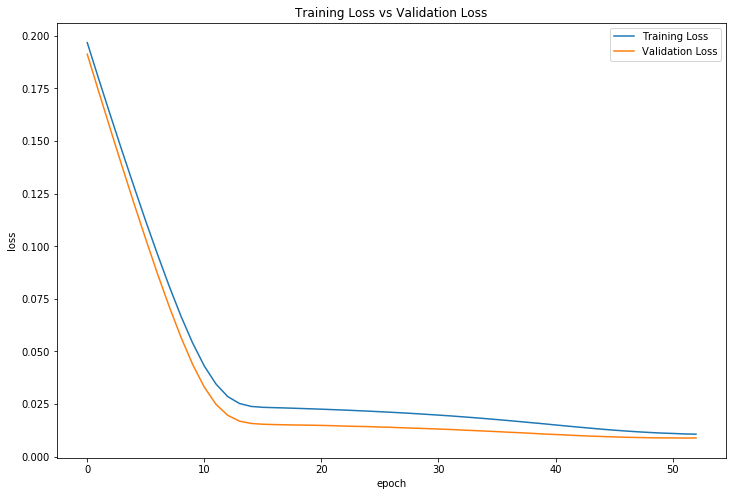

(1, 1660) (1660, 1) (1, 330) (330, 1)
(1660, 1) (1660, 1) (330, 1) (330, 1)
Train Score: 2.71 RMSE
Test Score: 2.48 RMSE


Split-6
1992 331
Length of Taining and Test Sets along with their labels:
1991 1991 330 330
Current data shape:
(1991, 1) (1991,) (330, 1) (330,)
Reshaped data suitable for LSTM:
(1991, 1, 1) (1991,) (330, 1, 1) (330,)
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_61 (LSTM)               (None, 1, 6)              192       
_________________________________________________________________
lstm_62 (LSTM)               (None, 1, 4)              176       
_________________________________________________________________
lstm_63 (LSTM)               (None, 2)                 56        
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 3         
_________________________________________

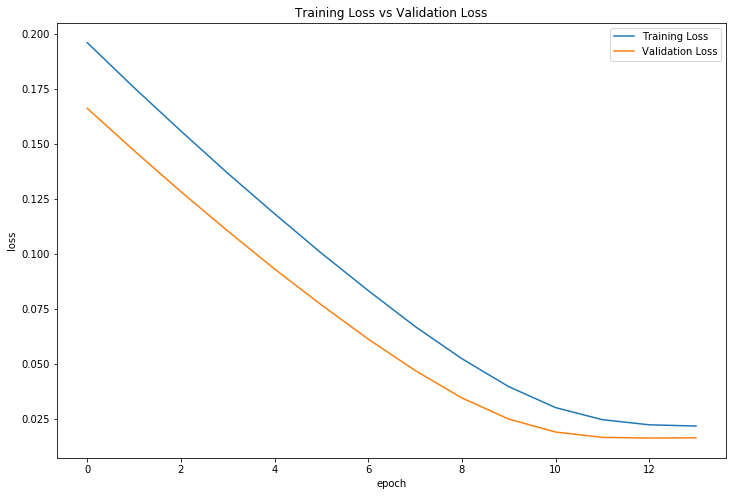

(1, 1991) (1991, 1) (1, 330) (330, 1)
(1991, 1) (1991, 1) (330, 1) (330, 1)
Train Score: 3.88 RMSE
Test Score: 3.38 RMSE


Split-7
2323 331
Length of Taining and Test Sets along with their labels:
2322 2322 330 330
Current data shape:
(2322, 1) (2322,) (330, 1) (330,)
Reshaped data suitable for LSTM:
(2322, 1, 1) (2322,) (330, 1, 1) (330,)
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_64 (LSTM)               (None, 1, 6)              192       
_________________________________________________________________
lstm_65 (LSTM)               (None, 1, 4)              176       
_________________________________________________________________
lstm_66 (LSTM)               (None, 2)                 56        
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 3         
_________________________________________

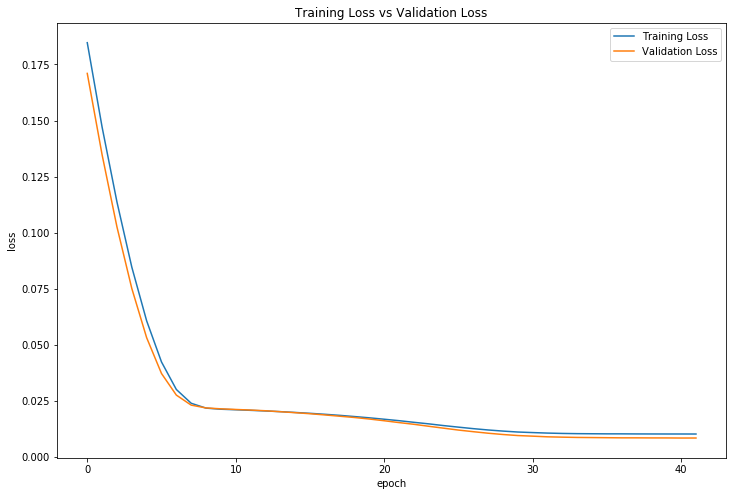

(1, 2322) (2322, 1) (1, 330) (330, 1)
(2322, 1) (2322, 1) (330, 1) (330, 1)
Train Score: 2.65 RMSE
Test Score: 2.41 RMSE


Split-8
2654 331
Length of Taining and Test Sets along with their labels:
2653 2653 330 330
Current data shape:
(2653, 1) (2653,) (330, 1) (330,)
Reshaped data suitable for LSTM:
(2653, 1, 1) (2653,) (330, 1, 1) (330,)
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_67 (LSTM)               (None, 1, 6)              192       
_________________________________________________________________
lstm_68 (LSTM)               (None, 1, 4)              176       
_________________________________________________________________
lstm_69 (LSTM)               (None, 2)                 56        
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 3         
_________________________________________

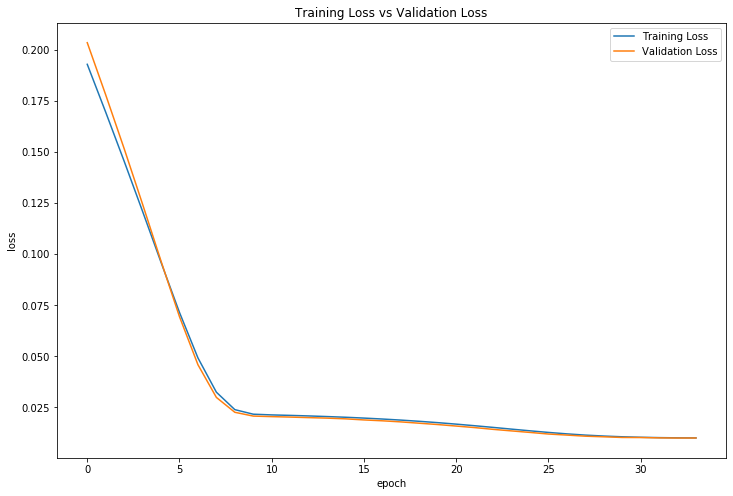

(1, 2653) (2653, 1) (1, 330) (330, 1)
(2653, 1) (2653, 1) (330, 1) (330, 1)
Train Score: 2.62 RMSE
Test Score: 2.63 RMSE


Split-9
2985 331
Length of Taining and Test Sets along with their labels:
2984 2984 330 330
Current data shape:
(2984, 1) (2984,) (330, 1) (330,)
Reshaped data suitable for LSTM:
(2984, 1, 1) (2984,) (330, 1, 1) (330,)
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_70 (LSTM)               (None, 1, 6)              192       
_________________________________________________________________
lstm_71 (LSTM)               (None, 1, 4)              176       
_________________________________________________________________
lstm_72 (LSTM)               (None, 2)                 56        
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 3         
_________________________________________

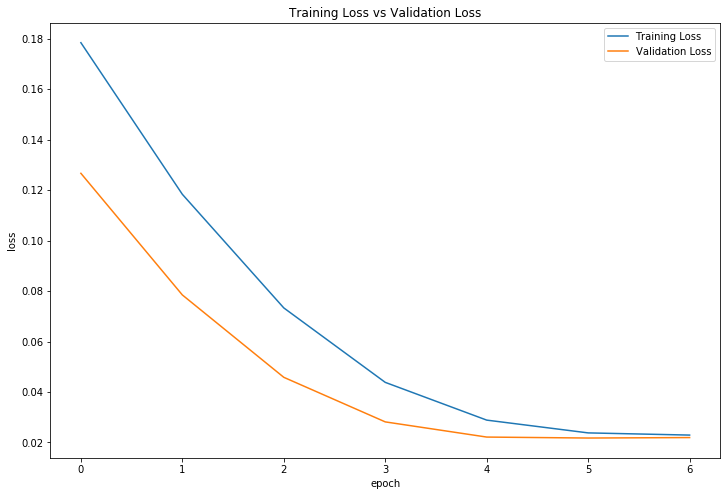

(1, 2984) (2984, 1) (1, 330) (330, 1)
(2984, 1) (2984, 1) (330, 1) (330, 1)
Train Score: 3.97 RMSE
Test Score: 3.90 RMSE


Split-10
3316 331
Length of Taining and Test Sets along with their labels:
3315 3315 330 330
Current data shape:
(3315, 1) (3315,) (330, 1) (330,)
Reshaped data suitable for LSTM:
(3315, 1, 1) (3315,) (330, 1, 1) (330,)
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_73 (LSTM)               (None, 1, 6)              192       
_________________________________________________________________
lstm_74 (LSTM)               (None, 1, 4)              176       
_________________________________________________________________
lstm_75 (LSTM)               (None, 2)                 56        
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 3         
________________________________________

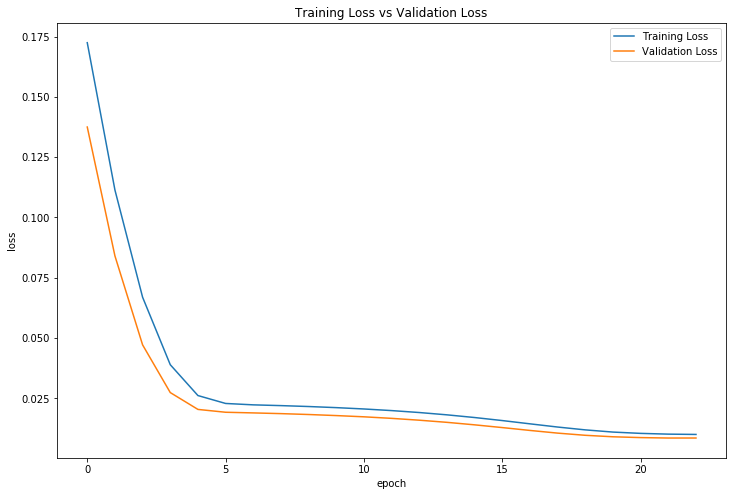

(1, 3315) (3315, 1) (1, 330) (330, 1)
(3315, 1) (3315, 1) (330, 1) (330, 1)
Train Score: 2.64 RMSE
Test Score: 2.44 RMSE




In [86]:
#k = 10

from sklearn.metrics import mean_squared_error
from math import sqrt

splits = TimeSeriesSplit(n_splits=10)
index = 1

for train_index, test_index in splits.split(X):
    
    print(f'Split-{index}') 
    
    train_X = X[train_index]
    test_X = X[test_index]
    
    print(len(train_X), len(test_X))
    
    def create_dataset(X, look_back=1):
        dataX, dataY = [], []
        for i in range(len(X)-1):
            a = X[i:(i+look_back), 0]
            dataX.append(a)
            dataY.append(X[i + look_back, 0])
        return np.array(dataX), np.array(dataY)

    # reshape into X=t and Y=t+1
    look_back = 1
    train_X, train_Y = create_dataset(train_X, look_back)
    test_X, test_Y = create_dataset(test_X, look_back)
    
    print("Length of Taining and Test Sets along with their labels:")
    print(len(train_X),len(train_Y),len(test_X),len(test_Y))
    
    print("Current data shape:")
    print(train_X.shape,train_Y.shape,test_X.shape,test_Y.shape)
    
    train_X = train_X.reshape(train_X.shape[0], 1, train_X.shape[1])
    test_X = test_X.reshape(test_X.shape[0], 1, test_X.shape[1])
    
    #Reshaped data suitable for LSTM:
    print("Reshaped data suitable for LSTM:")
    print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)
    
    model = Sequential()
    
    model.add(LSTM(6, batch_input_shape = (None, train_X.shape[1], train_X.shape[2]), return_sequences=True))
    model.add(LSTM(4, return_sequences=True))
    model.add(LSTM(2, return_sequences=False))    
    model.add(Dense(1))
        
    model.add(Dense(1))
    
        
    model.compile(loss = "mse", optimizer = "adam", metrics = ['mse'])
    model.summary()
    
    history = model.fit(train_X, train_Y, epochs = 250, validation_data = (test_X, test_Y), batch_size = 128, verbose = 2, callbacks=[es])

    index += 1
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Training Loss vs Validation Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
    plt.show()
    
    # LSTM Prediction:
    trainPredict = model.predict(train_X)
    testPredict = model.predict(test_X)
    
    # inverting the predictions to original scale
    trainPredict = scaler.inverse_transform(trainPredict)
    train_Y = scaler.inverse_transform([train_Y])

    testPredict = scaler.inverse_transform(testPredict)
    test_Y = scaler.inverse_transform([test_Y])
    
    print(train_Y.shape, trainPredict.shape, test_Y.shape, testPredict.shape)
    
    train_Y = train_Y.reshape(train_Y.shape[1], train_Y.shape[0])
    test_Y = test_Y.reshape(test_Y.shape[1], test_Y.shape[0])

    print(train_Y.shape, trainPredict.shape, test_Y.shape, testPredict.shape)
    
    #Calculating RMSE:

    training_Error = sqrt(mean_squared_error(train_Y, trainPredict))
    print('Train Score: %.2f RMSE' % (training_Error))

    test_Error = sqrt(mean_squared_error(test_Y, testPredict))
    print('Test Score: %.2f RMSE' % (test_Error))
    
    print("\n")

We see that both for the 5-fold and 10-fold Cross Validation, the results are close to our predicted model.

Hence, we can confirm that our model is safe to rely on to predict the temperatures.

SARIMA Results vs LSTM Results:


SARIMA (Seasonal Autoregressive Integrated Moving Average):
    
    method for time series forecasting is used on univariate data containing trends and seasonality. SARIMA is composed of trend and seasonal elements of the series.

ARIMA model fits the non-stationary time series based on the ARMA model, with a differencing process which effectively transforms the non-stationary data into a stationary one. 

SARIMA models, which combine seasonal differencing with an ARIMA model, are used for time series data modeling with periodic characteristics.

using only ARIMA model, it is hard to model the nonlinear relationships between variable.

ARIMA is a linear regression based forecasting approach, best suited for forecasting one-step out-of-sample forecast.

RMSE can be used as an error metric to evaluate performance of the model and to assess the accuracy of the prediction and evaluate the forecasts.

Both in terms of learning how it works, and the implementation, the LSTM-model provides considerably more options for fine-tuning compared to ARIMA

Several research and studies have found that a single LSTM network that is trained with a particular dataset is very likely to perform poorly on an entirely different timeseries unless rigorous parameter optimization is performed. 

As LSTM is very successful in forecasting when multiple LSTM networks are stacked and combined to provide a more accurate prediction, aiming to propose a more generalized model to forecasting problems

Research by other Data Scientists on four different forecasting problems, have concluded that the stacked LSTM networks outperformed the regular LSTM networks as well as the ARIMA model, in terms of the evaluation measure RMSE when compared together.

The general quality of the ensemble method studied could be increased through tuning the parameters for each individual LSTM.

Hence the concept of ensembling LSTM networks evolved to yield a better choice for forecasting problems, to reduce the need to heavily optimize parameters and to increase the quality of the predictions.

Hybrid ensemble learning with Long Short-Term Memory (LSTM), as depicted in the above figure can be used to forecast financial time series. AdaBoost algorithm is used to combine predictions from several individual Long Short-Term Memory (LSTM) networks.


Dataset, problem and Model Selection:

    The amount by which performance metrics differ in classical time-series models (ARIMA/SARIMA) vs deep learning models.

    The business impact long-term or short-term created due to model selection.
    
    Design, Implementation and maintenance cost of the more complex model.
    
    The loss of interpretability.
    
First, the data are highly dynamic. It is often difficult to tease out the structure that is embedded in time series data. 

Second, time series data can be nonlinear and contain highly complex autocorrelation structure. 

Data points across different periods of time can be correlated with each other and a linear approximation sometimes fails to model all the structure in the data. 

Traditional methods such as autoregressive models attempt to estimate parameters of a model that can be viewed as a smooth approximation to the structure that generated the data.

ARIMA has been found to better model data that follow linear relationships while RNN (depending on the activation function) better model data that has non-linear relationships. 

Conclusion:

    ARIMA yields better results in forecasting short term, whereas LSTM yields better results for long term modeling.
    
    ARIMA) focus on univariate data with linear relationships and fixed and manually-diagnosed temporal dependence.
    
    Classical methods like ETS and ARIMA out-perform machine learning and deep learning methods for one-step forecasting on univariate datasets.
    
    Classical methods like ARIMA focus on fixed temporal dependence: the relationship between observations at different times, which necessitates analysis and specification of the number of lag observations provided as input.
    
    Machine learning and deep learning methods do not yet deliver on their promise for univariate time series forecasting and there is much research left to be done.
    
    As LSTMs are equipped to to learn long term correlations in a sequence, they can model complex multivariate sequences without the need to specify any time window .